In [1]:
import numpy as np
import tensorflow as tf
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
import nibabel as nib
from math import sqrt
import metric_util


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Tensor completion

In this example we will see how can we do tensor completion with t3f, i.e. observe a fraction of values in a tensor and recover the rest by assuming that the original tensor has low TT-rank.
Mathematically it means that we have a binary mask $P$ and a ground truth tensor $A$, but we observe only a noisy and sparsified version of $A$: $P \odot (\hat{A})$, where $\odot$ is the elementwise product (applying the binary mask) and $\hat{A} = A + \text{noise}$. In this case our task reduces to the following optimization problem:
\begin{equation*}
\begin{aligned}
& \underset{X}{\text{minimize}} 
& & \|P \odot (X - \hat{A})\|_F^2 \\
& \text{subject to} 
& & \text{tt_rank}(X) \leq r_0
\end{aligned}
\end{equation*}



### Generating problem instance,
Lets generate a random matrix $A$, noise, and mask $P$.

In [2]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)
#x_true_org = image.index_img(x_true_org,1)
x_true_org1 = mt.read_image_abs_path(subject_scan_path)

Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [3]:
x_true_img = np.array(x_true_org.get_data())

In [4]:
#shape = (3, 4, 4, 5, 7, 5)
shape = (53,63,46,144)
# Fix random seed so the results are comparable between runs.
tf.set_random_seed(0)
# Generate ground truth tensor A. To make sure that it has low TT-rank,
# let's generate a random tt-rank 5 tensor and apply t3f.full to it to convert to actual tensor.
#ground_truth = t3f.full(t3f.random_tensor(shape, tt_rank=5))
ground_truth = x_true_img
# Make a (non trainable) variable out of ground truth. Otherwise, it will be randomly regenerated on each sess.run.
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
noise = 1e-2 * tf.get_variable('noise', initializer=tf.random_normal(shape), trainable=False)
noisy_ground_truth = ground_truth + noise
ten_zeros = np.zeros_like(x_true_img)
Lold = tf.get_variable('Lold', initializer=ground_truth)
Sold = tf.get_variable('Sold', initializer=ten_zeros)

# Observe 25% of the tensor values.
sparsity_mask = tf.cast(tf.random_uniform(shape) <= 0.80, tf.float32)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=sparsity_mask, trainable=False)
sparse_observation = noisy_ground_truth * sparsity_mask

### Initialize the variable and compute the loss

In [5]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [6]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / (frobenius_norm_tf(x_true))
    return percent_error

In [7]:
def cost_with_treshold(x, thresh = 0.03):
    res = tf.abs(x)
    zeros = tf.zeros_like(x)
    masked = tf.greater(res, thresh)
    new_tensor = tf.where(masked, x, zeros)
    return new_tensor

In [8]:
observed_total = tf.reduce_sum(sparsity_mask)
total = np.prod(shape)
ranks_a = np.array([53,63,46,144,1])
tt_with_ranks = t3f.to_tt_tensor(x_true_img, max_tt_rank=144)
ranks = shapes.tt_ranks(tt_with_ranks)
initialization = t3f.random_tensor(shape, tt_rank=10)
l_tf = t3f.to_tt_tensor(x_true_img, max_tt_rank=144)
L = t3f.get_variable('L', initializer=l_tf)
ground_truth_tf = t3f.to_tt_tensor(ground_truth, max_tt_rank=63)
Lnew = ground_truth - cost_with_treshold(ground_truth - t3f.full(L))
S = ground_truth - Lnew
# Loss is MSE between the estimated and ground-truth tensor as computed in the observed cells.
#loss = tf.reduce_sum((ground_truth - cost_with_treshold(ground_truth - t3f.full(L)))**2)/(tf.reduce_sum(ground_truth)**2)
loss = tf.reduce_sum((ground_truth - Lnew - S)**2)/(tf.reduce_sum(ground_truth)**2)
# Test loss is MSE between the estimated tensor and full (and not noisy) ground-truth tensor A.

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 144, 1, 1] 1 (53, 63, 144)
[1, 53, 144, 144, 1] 2 (144, 46, 144)
ranks: [1, 53, 144, 144, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 144, 1, 1] 1 (53, 63, 144)
[1, 53, 144, 144, 1] 2 (144, 46, 144)
ranks: [1, 53, 144, 144, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [9]:
shape

(53, 63, 46, 144)

# SGD optimization
The simplest way to solve the optimization problem is Stochastic Gradient Descent: let TensorFlow differentiate the loss w.r.t. the factors (cores) of the TensorTrain decomposition of the estimated tensor and minimize the loss with your favourite SGD variation.

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01, epsilon=1e-18)
step = optimizer.minimize(loss)

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_loss_hist = []
test_loss_hist = []
for i in range(200):
    _, tr_loss_v = sess.run([step, loss])
    train_loss_hist.append(tr_loss_v)
    print(i, tr_loss_v)
    #if i % 1000 == 0:
     #   print(i, tr_loss_v, test_loss_v, rel_error1_v)

(0, 0.0)
(1, 0.0)
(2, 0.0)
(3, 0.0)
(4, 0.0)
(5, 0.0)
(6, 0.0)
(7, 0.0)
(8, 0.0)
(9, 0.0)
(10, 0.0)
(11, 0.0)
(12, 0.0)
(13, 0.0)
(14, 0.0)
(15, 0.0)
(16, 0.0)
(17, 0.0)
(18, 0.0)
(19, 0.0)
(20, 0.0)
(21, 0.0)
(22, 0.0)
(23, 0.0)
(24, 0.0)
(25, 0.0)
(26, 0.0)
(27, 0.0)
(28, 0.0)
(29, 0.0)
(30, 0.0)
(31, 0.0)
(32, 0.0)
(33, 0.0)
(34, 0.0)
(35, 0.0)
(36, 0.0)
(37, 0.0)
(38, 0.0)
(39, 0.0)
(40, 0.0)
(41, 0.0)
(42, 0.0)
(43, 0.0)
(44, 0.0)
(45, 0.0)
(46, 0.0)
(47, 0.0)
(48, 0.0)
(49, 0.0)
(50, 0.0)
(51, 0.0)
(52, 0.0)
(53, 0.0)
(54, 0.0)
(55, 0.0)
(56, 0.0)
(57, 0.0)
(58, 0.0)
(59, 0.0)
(60, 0.0)
(61, 0.0)
(62, 0.0)
(63, 0.0)
(64, 0.0)
(65, 0.0)
(66, 0.0)
(67, 0.0)
(68, 0.0)
(69, 0.0)
(70, 0.0)
(71, 0.0)
(72, 0.0)
(73, 0.0)
(74, 0.0)
(75, 0.0)
(76, 0.0)
(77, 0.0)
(78, 0.0)
(79, 0.0)
(80, 0.0)
(81, 0.0)
(82, 0.0)
(83, 0.0)
(84, 0.0)
(85, 0.0)
(86, 0.0)
(87, 0.0)
(88, 0.0)
(89, 0.0)
(90, 0.0)
(91, 0.0)
(92, 0.0)
(93, 0.0)
(94, 0.0)
(95, 0.0)
(96, 0.0)
(97, 0.0)
(98, 0.0)
(99, 0.0)
(100, 0.0)

/usr/local/lib/python2.7/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


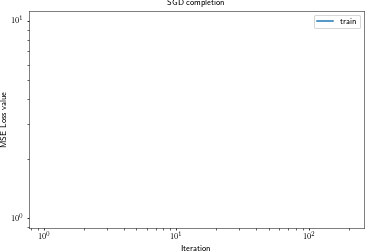

In [12]:
plt.loglog(train_loss_hist, label='train')
#plt.loglog(test_loss_hist, label='test')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss value')
plt.title('SGD completion')
plt.legend()


In [13]:
#ground_truth_var = t3f.get_variable('ground_truth', initializer=ground_truth, reuse=True)

In [ ]:
#ground_truth.read_value()
ground_truth_val = ground_truth.eval(session=sess)

In [ ]:
estimated_val = sess.run(t3f.full(estimated))

In [ ]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [ ]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [ ]:
rel_error

In [ ]:
#ten_ones = np.ones_like(mask)
#x_reconstr = mt.reconstruct(x_hat,x_true, ten_ones, mask)

In [ ]:
estimated_val.shape

In [ ]:
from nilearn import image

In [ ]:
shape = (53,63,46,144)

In [ ]:
sparse_observation_val=sparse_observation.eval(session=sess)

In [ ]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, sparse_observation_val)

In [ ]:
#x_miss = x_miss_img
x_miss = image.index_img(x_miss_img,1)

In [ ]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, estimated_val)


In [ ]:
#x_hat = x_hat_img
x_hat = image.index_img(x_hat_img,1)

In [ ]:
from nilearn import plotting

In [ ]:
x_true_org = image.index_img(x_true_org,1)

In [ ]:
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [ ]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [ ]:
import ellipsoid_masker as elpm
import ellipsoid_mask as em

In [ ]:
def create_corrupted_image(x0,y0,z0, x_r, y_r):
    pass

In [ ]:
def generate_structural_missing_pattern(x0,y0,z0, x_r, y_r, frames_count, path_folder):
    subject_scan_path = du.get_full_path_subject1()
        
    print ("3D Random Missing Value Pattern Simulations has started...")
    print "Subject Path: " + str(subject_scan_path)
    
    n = 0
    # type 1 (center is the center of the image), corrupt first 10 frames
    #x0, y0, z0 = (0 ,-18 , 17)
    #x_r, y_r, z_r = (20, 17, 15)
    
    print "===Type 1 Experiments===="
    
    target_img = image.index_img(subject_scan_path,n)
    
    type_1_folder_path = path_folder
    masked_img_file_path  = type_1_folder_path + "/" + "size_" + str(x_r) + "_" + str(y_r) + "_" + str(z_r) + "_scan_" + str(n)
    
    corrupted_volumes_list = []
    corrupted_volumes_list_scan_numbers = []
    
    for i in xrange(frames_count):
        masked_img_file_path  = type_1_folder_path + "/" + "size_" + str(x_r) + "_" + str(y_r) + "_" + str(z_r) + "_scan_" + str(i)
        target_img = image.index_img(subject_scan_path,i)
        image_masked_by_ellipsoid = elpm.create_ellipsoid_mask(x0, y0, z0, x_r, y_r, z_r, target_img, masked_img_file_path)
        
        masked_img_file_path = masked_img_file_path + ".nii"
        ellipsoid = em.EllipsoidMask(x0, y0, z0, x_r, y_r, z_r, masked_img_file_path)
        ellipsoid_volume = ellipsoid.volume()
        observed_ratio = mt.compute_observed_ratio(image_masked_by_ellipsoid)
        
        corrupted_volumes_list.append(image_masked_by_ellipsoid)
        corrupted_volumes_list_scan_numbers.append(i)
        print ("Ellipsoid Volume: " + str(ellipsoid_volume) + "; Missing Ratio: " + str(observed_ratio))
    
    # now create corrupted 4d where fist 10 frames has ellipsoid missing across 10 frames
    counter = 0
    
    volumes_list = []
    for img in image.iter_img(subject_scan_path):
        print "Volume Index: " + str(counter)
        if counter in corrupted_volumes_list_scan_numbers:
            print "Adding corrupted volume to the list " + str(counter)
            volumes_list.append(corrupted_volumes_list[counter])
        else:
            print "Adding normal volume to the list " + str(counter)
            volumes_list.append(img)
        counter = counter + 1
        
    # now generate corrupted 4D from the list
    corrupted4d_10 = image.concat_imgs(volumes_list)
    print "Corrupted 4D - 10 frames: " + str(corrupted4d_10)
    observed_ratio4D_10 = mt.compute_observed_ratio(corrupted4d_10)
    print ("Corrupted 4D - 10 Volume: " + "; Missing Ratio: " + str(observed_ratio4D_10))
    corr_file_path4D = du.corrupted4D_10_frames_path()
    nib.save(corrupted4d_10, corr_file_path4D)
    return corrupted4d_10

In [ ]:
def get_xyz(i, j, k, epi_img):
    M = epi_img.affine[:3, :3]
    abc = epi_img.affine[:3, 3]
    return M.dot([i, j, k]) + abc

In [ ]:
coord = [26,31,23]
path_folder3D = "/work/el/3D"

In [ ]:
x_true_org3D = image.index_img(subject_scan_path,0)
nib.save(x_true_org3D,path_folder3D)

In [ ]:
x_coord  = get_xyz(10,7,4, x_true_org3D)

In [ ]:
x_coord

In [ ]:
x_coord_center  = get_xyz(26,31,23, x_true_org3D)

In [ ]:
x_coord_center

In [ ]:
path_folder3D = "/work/el/3D"

In [ ]:
path_folder = "/work/el/75"

In [ ]:
#x0, y0, z0 = (-10, -20,17)
#x0, y0, z0 = (-5, -20,17)
#x0, y0, z0 = (2, 32,22)
#x_r, y_r, z_r = (20,17,15)
x0, y0, z0 = (2, 32,22)
# size 1
#x_r, y_r, z_r = (7,10,8)
# size 2
#x_r, y_r, z_r = (9,10,8)
#size 3
x_r, y_r, z_r = (12,10,8)

In [ ]:
x_miss_img = generate_structural_missing_pattern(x0,y0,z0, x_r, y_r, 1, path_folder)

In [ ]:
x_miss_img

In [ ]:
x_miss_img_data = np.array(x_miss_img.get_data())

In [ ]:
mask = elpm.ellipsoid_masker(x_r, y_r, z_r, x0, y0, z0, x_true_org3D)

In [ ]:
mask_data = np.array(mask.get_data())

In [ ]:
mask.shape

In [ ]:
mask_data.shape

In [ ]:
def generate_system_noise_roi_mask(img, snr_db, mask):
    snr = sqrt(np.power(10.0, snr_db / 10.0))
    print ("snr: " + str(snr))
    data = np.array(img.get_data())
    signal = data[mask > 0].reshape(-1)
    sigma_n = signal.mean() / snr
    print ("sigma_n: " + str(sigma_n))
    n_1 = np.random.normal(size=data.shape, scale=sigma_n)
    n_2 = np.random.normal(size=data.shape, scale=sigma_n)
    stde_1 = n_1 / sqrt(2.0)
    stde_2 = n_2 / sqrt(2.0)
    im_noise = np.sqrt((data + stde_1)**2 + (stde_2)**2)
    im_noise[mask == 0] = 0
    noise_idxs = np.where(im_noise > 0)
    data[noise_idxs] = im_noise[noise_idxs]
    return data, im_noise

In [ ]:
def create_noisy_image(x, snr_db, mask):
    x_noisy, noise_mask = generate_system_noise_roi_mask(x, snr_db, mask)
    x_noisy_img = mt.reconstruct_image_affine(x, x_noisy)
    noise_mask_img = mt.reconstruct_image_affine(x, noise_mask)
    return x_noisy_img, noise_mask_img

In [ ]:
noisy_roi = generate_system_noise(x_true_org3D, 2, mask_data)

In [ ]:
data_x = np.array(x_true_org3D.get_data())

In [ ]:
data1 = data_x*(1./np.linalg.norm(data_x))

In [ ]:
#1./np.linalg.norm(self.x_init)

In [ ]:
idxs = np.where(noisy_roi > 0)

In [ ]:
data1[mask_data == 1] = 0 

In [ ]:
ss = data1 + noisy_roi

In [ ]:
data1[x_r +2 , y_r +2, z_r +2]

In [ ]:
noisy_roi_img = mt.reconstruct_image_affine(x_true_org3D, noisy_roi)

In [ ]:
x_n, noise_mask = create_noisy_image(x_true_org3D, 2, mask_data)

In [ ]:
ss[x_r +2 , y_r +2, z_r +2]

In [ ]:
disp = plotting.plot_img(x_true_org3D, bg_img=None,black_bg=True, cmap='jet', cut_coords=[x0, y0, z0]) 
#disp.add_contours(mask, levels=[0.1, 0.3, 0.4, 0.5], filled=False, colors='b')
disp.add_overlay(noise_mask, alpha = 0.7)

In [ ]:
counter = 0
volumes_list = []
for img in image.iter_img(subject_scan_path):
    print "Volume Index: " + str(counter)
    if counter == 0:
        print "Adding corrupted volume to the list " + str(counter)
        volumes_list.append(x_n)
    else:
        print "Adding normal volume to the list " + str(counter)
        volumes_list.append(img)
        counter = counter + 1
        
    # now generate corrupted 4D from the list
x_corr_img = image.concat_imgs(volumes_list)

In [ ]:
mask_img_data = np.array(x_corr_img.get_data())


In [ ]:
print mask_img_data.shape

In [ ]:
print mask_indices_img

In [ ]:
mask_indices = np.ones_like(mask_img_data)
mask_indices[mask_img_data == 0] = 0.0
mask_indices_img = mt.reconstruct_image_affine(x_true_org1, mask_indices)

In [ ]:
from nilearn.masking import apply_mask
masked_data = apply_mask(x_corr_img, mask)

In [ ]:
print x_corr_img

In [ ]:
masked_data.shape

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(masked_data[:148, :25])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 143)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)


In [ ]:
x_miss_img_data.shape

In [ ]:
print x_true_org

In [ ]:
target_img = image.index_img(x_true_org1,0)

In [ ]:
masked_img_file_path  = "/work/el" + "/" + "size_" + str(x_r) + "_" + str(y_r) + "_" + str(z_r) + "_scan_" + str(i)

In [ ]:
masked_img_file_path

In [ ]:
image_masked_by_ellipsoid = elpm.create_ellipsoid_mask(x0, y0, z0, x_r, y_r, z_r, target_img, masked_img_file_path)

In [ ]:
target_img

In [ ]:
import nipy

In [ ]:
image_masked_by_ellipsoid

In [ ]:
n_spikes, out_spikes, out_fft, spikes_list = slice_wise_fft(subject_scan_path, spike_thres=4.)

In [ ]:
out_fft

In [ ]:
n_spikes

In [ ]:
spiked_fft = mt.read_image_abs_path(out_fft)

In [ ]:
print spiked_fft

In [ ]:
tr_6_img = image.index_img(x_true_org1, 39)

In [ ]:
mean_fft_img = image.mean_img(spiked_fft)

In [ ]:
spike_6_img = image.index_img(spiked_fft,39)

In [ ]:
spike_6 = plotting.plot_img(spike_6_img, display_mode='z', bg_img=None,black_bg=True, cmap='Greys_r', cut_coords=[18])
spike_6.add_contours(z_score_d_mask_img, levels=[0.5], filled=True, alpha=0.8, colors='r')

In [ ]:
tr_6 = plotting.plot_epi(tr_6_img, display_mode='z', bg_img=None,black_bg=True,cut_coords=[18]) 


In [ ]:
#z_score_epi_mask = get_z_score_robust_spatial_mask(tr_6_img, 4) 